# Save global JSL drag coefficient, match the tides_025 (MOM6-example) grid 

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors as colors
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p

import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45091,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:35315,Total threads: 1
Dashboard: /proxy/46613/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38335,


In [3]:
nx = 360
ny = 180
lat_JSL = np.full((ny),np.nan)
lon_JSL = np.full((nx),np.nan)
sigma_JSL = np.full((ny,nx),np.nan)
depth_z = np.full((ny,nx),np.nan)

## Loop through tiles and re-construct drag coefficient arrays

In [4]:
for i in range(400):
    # print(i+1)
    filename_JSL = '/g/data/nm03/lxy581/global_drag_coeff/sigma_JSL_2d_%03d.nc' % (i+1)
    # print(filename)
    itile_JSL = xr.open_dataset(filename_JSL)

    # infer the lon & lat from itile
    ilon = i//20+1
    ilat = i+1 - (ilon-1)*20
    # print(ilon,ilat)
    
    lon_JSL[(ilon-1)*18:ilon*18] = itile_JSL.lon
    lat_JSL[(ilat-1)*9:ilat*9] = itile_JSL.lat
    sigma_JSL[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_JSL.sigma_JSL

0.3.0


## Ocean depth

In [5]:
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')

def get_depth(lon,lat):
    return topog.z.interp(lat=lat,lon=lon).values

In [6]:
for j in range(ny):
    for i in range(nx):
        depth_z[j,i] = get_depth(lon_JSL[i],lat_JSL[j])

In [7]:
depth_z[depth_z>0]=np.nan
depth_xr = xr.DataArray(depth_z, coords={'lat': lat_JSL, 'lon': lon_JSL}, dims=["lat", "lon"])

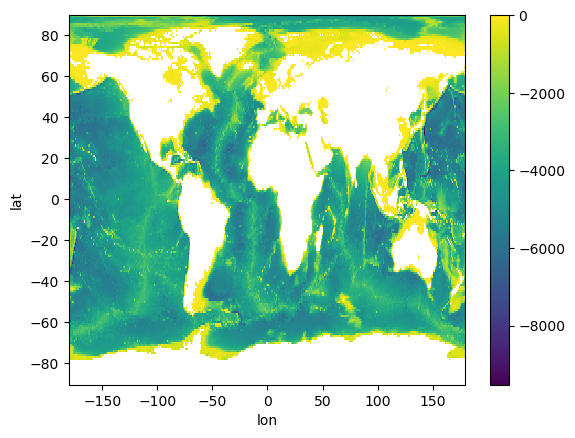

In [8]:
depth_xr.plot()

In [9]:
sigma_JSL_xr = xr.DataArray(sigma_JSL, coords={'lat': lat_JSL, 'lon': lon_JSL}, dims=["lat", "lon"])

## Interpolate to remove the missing band near 180°

In [10]:
mask_JSL = ~np.isnan(sigma_JSL)
ds_JSL = xr.Dataset(data_vars={
                    'sigma': (('lat','lon'), sigma_JSL),
                    'mask': (('lat','lon'), mask_JSL)
                    }, 
                    coords={'lon': sigma_JSL_xr.lon,'lat': sigma_JSL_xr.lat})
ds_out_JSL = xr.Dataset({"lat": (["lat"], lat_JSL[16:-16]),
                         "lon": (["lon"], lon_JSL),
                         "mask": (["lat","lon"], ~np.isnan(depth_z[16:-16,:]))})
regridder = xe.Regridder(ds_JSL, ds_out_JSL, "bilinear", extrap_method="inverse_dist")
ds_out_JSL = regridder(ds_JSL)

## Interpolate to 1/4° grid

In [20]:
fgrid = '/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025_JSL/INPUT/ocean_hgrid.nc' 
hgrid = xr.open_dataset(fgrid)
mom_lon_q = np.array(hgrid.x)
mom_lat_q = np.array(hgrid.y)
mom_nyq, mom_nxq = mom_lon.shape
mom_nyh = mom_nyq - 1
mom_nxh = mom_nxq - 1
mom_lon = np.full((mom_nyh,mom_nxh),np.nan)
mom_lat = np.full((mom_nyh,mom_nxh),np.nan)
for j in range(mom_nyh):
    for i in range(mom_nxh):
        mom_lon[j,i] = 0.5*(mom_lon_q[j,i] + mom_lon_q[j+1,i+1])
        mom_lat[j,i] = 0.5*(mom_lat_q[j,i] + mom_lat_q[j+1,i+1])

In [22]:
mom_ny, mom_nx = mom_lon.shape

In [23]:
ds_low_JSL = xr.Dataset(data_vars={
                                   'sigma_25': (('lat','lon'), np.array(ds_out_JSL['sigma'])),
                                   'mask': (('lat','lon'), ~np.isnan(depth_z[16:-16,:]))
                                   }, 
                        coords={'lon': ds_out_JSL['lon'],'lat': ds_out_JSL['lat']})
ds_high_JSL = xr.Dataset(data_vars={"lat": (["y","x"], mom_lat),
                                    "lon": (["y","x"], mom_lon),
                                    },
                         coords={"y":np.arange(mom_ny), "x":np.arange(mom_nx)})
regridder2 = xe.Regridder(ds_low_JSL, ds_high_JSL, "bilinear", extrap_method="inverse_dist")
ds_high_JSL = regridder2(ds_low_JSL)

In [24]:
ds_low_dep = xr.Dataset(data_vars={
                                   'depth_25': (('lat','lon'), depth_z),
                                   }, 
                        coords={'lon': lon_JSL,'lat': lat_JSL})
ds_high_dep = xr.Dataset(data_vars={"lat": (["y","x"], mom_lat),
                                    "lon": (["y","x"], mom_lon),
                                    },
                        coords={"y":np.arange(mom_ny), "x":np.arange(mom_nx)})
regridder3 = xe.Regridder(ds_low_dep, ds_high_dep, "bilinear", extrap_method="inverse_dist")
ds_high_dep = regridder3(ds_low_dep)

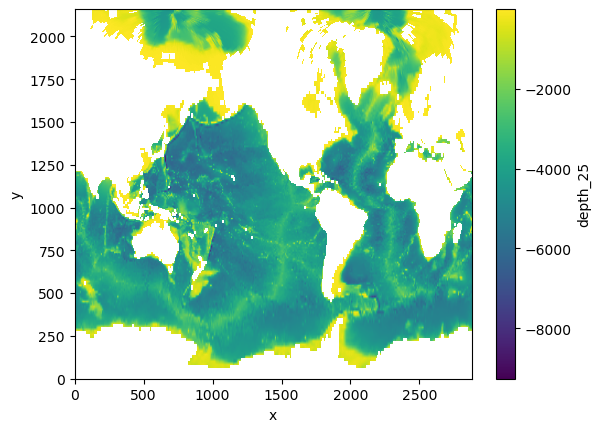

In [25]:
ds_high_dep['depth_25'].plot()

### Critical latitude for M2

In [26]:
omega = 2 * np.pi / (12.42*3600)
f_loc = f(74.48) 
print(omega)
print(f_loc)

0.0001405257046694307
0.00014052446836156188


### Save JSL drag coefficient to file

In [27]:
JSL_global = np.zeros((mom_ny,mom_nx))

JSL_global = np.array(ds_high_JSL['sigma_25'])
dep_global = np.array(ds_high_dep['depth_25'])
JSL_global[np.isnan(dep_global)==1]=0.0

JSL_global[mom_lat>74.48]=0.0
JSL_global[mom_lat<-74.48]=0.0

JSL_data = xr.Dataset(data_vars={"sigma_JSL": (["y","x"], JSL_global)},
                      coords={"lat": (["y","x"], mom_lat), 
                              "lon": (["y","x"], mom_lon)})

JSL_data.to_netcdf('/g/data/nm03/lxy581/global_drag_coeff/sigma_JSL_2d_global.nc')

In [28]:
JSL_data['sigma_JSL']

<xarray.DataArray 'sigma_JSL' (y: 2160, x: 2880)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lat      (y, x) float64 -79.82 -79.82 -79.82 -79.82 ... 64.2 64.14 64.09
    lon      (y, x) float64 -299.8 -299.7 -299.5 -299.4 ... 60.0 60.0 60.0 60.0
Dimensions without coordinates: y, x

## Plot drag coefficient

In [29]:
def plot_global(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

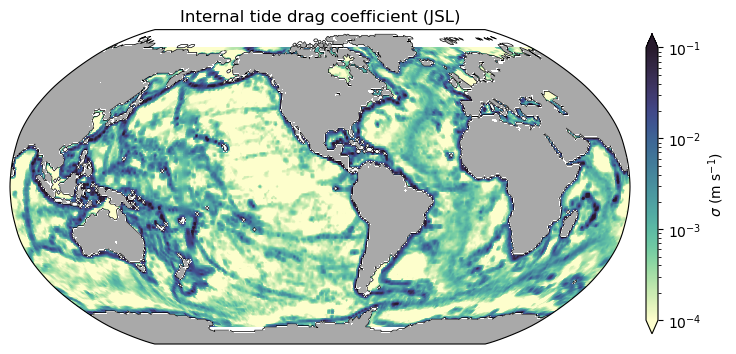

In [30]:
plot_global(JSL_data['lon'],JSL_data['lat'],JSL_data['sigma_JSL'],1e-4,1e-1,'Internal tide drag coefficient (JSL)',cmap=cm.cm.deep)